https://www.kaggle.com/c/dogs-vs-cats/data

# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


Using TensorFlow backend.


# Define Constants

In [2]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT

(3, 128, 128)

# Prepare Traning Data

In [4]:
path = "../input/ct-haem/Data_files/train_data/"
filenames = os.listdir("../input/ct-haem/Data_files/train_data/")
df = pd.read_csv("../input/ct-haem/Data_files/train_labels.csv")

In [5]:
df['filename'] = df['filename']+'.png'

In [6]:
df.head()

,filename,value
0,Train_0.png,1
1,Train_1.png,1
2,Train_2.png,0
3,Train_3.png,0
4,Train_4.png,1


### See Total In count

From our data we have 12000 cats and 12000 dogs

# See sample image

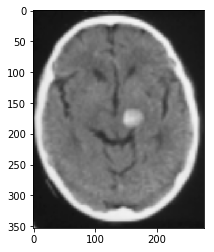

In [7]:
sample = random.choice(filenames)
image = load_img(path+sample)
plt.imshow(image)
plt.show()

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
#from keras.applications.mobilenet import MobileNet


# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

# #adam_opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()


def define_model():
    # load model
    #model = MobileNet(include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    model = VGG16(include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

    # mark loaded layers as not trainable
#     for layer in model.layers:
#         layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    #opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = define_model()

# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# # model.add(Conv2D(64, (3, 3)))
# # model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Dense(2))
# model.add(Activation('softmax'))

# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

# Callbacks

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [10]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
checkpt = ModelCheckpoint('vgg3_weights{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [13]:
csvsave = CSVLogger('vgg3_log.csv', separator=',', append=False)

In [14]:
callbacks = [earlystop, learning_rate_reduction, checkpt, csvsave]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [ ]:
df["value"] = df["value"].replace({0: 'no', 1: 'yes'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df['value'].value_counts().plot.bar()
plt.show()


In [ ]:
validate_df['value'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
print(total_train)

# Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1
)



In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path, 
    x_col='filename',
    y_col='value',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path, 
    x_col='filename',
    y_col='value',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# See how our generator work

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '../input/ct-haem/Data_files/train_data/', 
    x_col='filename',
    y_col='value',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

In [ ]:
# os.mkdir('train_100')

In [ ]:
# for file in os.listdir(path):
#     img = load_img(path+file)  # this is a PIL image
#     x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
#     x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

#     # the .flow() command below generates batches of randomly transformed images
#     # and saves the results to the `preview/` directory
#     i = 0
#     for batch in train_datagen.flow(x, batch_size=1,
#                               save_to_dir='train_100', save_prefix=file+"__", save_format='png'):
#         i += 1
#         if i > 100:
#             break  # otherwise the generator would loop indefinitely

In [ ]:
# tfiles = os.listdir('train_new')
# train_files = []
# train_values = []
# val_files = []
# val_values = []

# train_list = train_df['filename'].tolist()
# val_list = validate_df['filename'].tolist()
# for i in range(len(tfiles)):
#     name = tfiles[i][:tfiles[i].find("__")]
#     if name in train_list:
#         index = train_df['filename'].tolist().index(name)
#         value = train_df['value'][index]
#         train_values.append(value)
#         train_files.append(tfiles[i])
#     elif name in val_list:
#         index = validate_df['filename'].tolist().index(name)
#         value = validate_df['value'][index]
#         val_values.append(value)
#         val_files.append(tfiles[i])  
# train_10_df = pd.DataFrame(list(zip(train_files, train_values)), columns =['filename', 'value']) 
# val_10_df = pd.DataFrame(list(zip(val_files, val_values)), columns =['filename', 'value']) 

In [ ]:
# name = train_files[i][:train_files[i].find("__")]
# index = train_df['filename'].tolist().index(name)
# #train_df['filename'].values[0].index(name)
# train_df['value'][index]

# Fit Model

In [ ]:
# train_generator_new = train_datagen.flow_from_dataframe(
#     train_10_df, 
#     'train_new/', 
#     x_col='filename',
#     y_col='value',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

# validation_datagen = ImageDataGenerator(rescale=1./255)
# validation_generator_new = validation_datagen.flow_from_dataframe(
#     val_10_df, 
#     'train_new/', 
#     x_col='filename',
#     y_col='value',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

In [ ]:
# total_train_new = train_10_df.shape[0]
# total_validate_new = val_10_df.shape[0]
# batch_size=15
# print(total_train_new)

In [ ]:
total_train = train_df.shape[0]
total_validate =validate_df.shape[0]
batch_size=15
print(total_train)

In [ ]:
# epochs=50
# history = model.fit_generator(
#     train_generator_new, 
#     epochs=epochs,
#     validation_data=validation_generator_new,
#     validation_steps=total_validate_new//batch_size,
#     steps_per_epoch=total_train_new//batch_size,
#     callbacks=callbacks
# )

In [ ]:
epochs=50
batch_size = 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

# Save Model

In [ ]:
# model.save_weights("model.h5")

In [15]:
# model.load_weights("../working/vgg3_weights016.h5")
model.load_weights("../input/vgg3wts/vgg3_weights016.h5")

# Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Create Testing Generator

In [17]:
batch_size = 10
test_path = "../input/ct-haem/Data_files/test_data/"
test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/ct-haem/Data_files/test_data/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 50 validated image filenames.


# Predict

In [18]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['value'] = np.argmax(predict, axis=-1)

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

### Virtaulize Result

### See predicted result with images

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['value']
    img = load_img("../input/ct-haem/Data_files/test_data/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [ ]:
# submission_df = test_df.copy()
# submission_df['id'] = submission_df['filename'].str.split('.').str[0]
# submission_df['label'] = submission_df['category']
# submission_df.drop(['filename', 'category'], axis=1, inplace=True)
# submission_df.to_csv('submission_mobile10.csv', index=False)

In [ ]:
out = test_df

In [26]:
out.rename(index = {"filename": "id", 
                     "value":"label"}, 
                                 inplace = True) 

In [28]:
out.to_csv("hem.csv")